# Importing libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import itertools
import sqlite3
from datetime import date
from datetime import datetime

# Data Collection

In [2]:
loc = "C:/Users/domin/Desktop/DE/.SEM 4/Artificial Inteligence/"

In [3]:
con = sqlite3.connect(loc + "database.sqlite")
df_country = pd.read_sql_query("SELECT * from country", con)
df_league = pd.read_sql_query("SELECT * from league", con)
df_match = pd.read_sql_query("SELECT * from match", con)
df_player = pd.read_sql_query("SELECT * from player", con)
df_player_attributes = pd.read_sql_query("SELECT * from player_attributes", con)
df_team = pd.read_sql_query("SELECT * from team", con)
df_team_attributes = pd.read_sql_query("SELECT * from team_attributes", con)
con.close()

# Data Preparation and Data Visualisation

In [4]:
# Selecting the Spanish Football League (La Liga)
df_match=df_match[df_match['league_id'] == 21518]

# While taking several leagues we received significantly worse results, which indicates that every league has its own
# characteristic and we should train our model based on only one league so that the predictions are more consistent

In [5]:
# Function calculating difference between two dates, returning difference in number of days
def day_difference(d2,d1):
    d1 = datetime.strptime(d1,'%Y-%m-%d %H:%M:%S')
    d2 = datetime.strptime(d2, '%Y-%m-%d %H:%M:%S')
    return abs((d2 - d1).days)

In [6]:
# Defining our target dataframe which will contain data about all the matches within Spanish Football League 
# and all the attributes connected with those matches
all=pd.DataFrame

In [7]:
# Assigning additional attributes containing additional information about matches and the most recent FIFA attributes 
# to the teams participating in a particular match based on a date of the match
def add_relevant_attributes(merged_df, home_or_away):
    if merged_df.empty:
        merged_df=pd.merge(df_match,df_team.add_suffix('_' + home_or_away), left_on=home_or_away + '_team_api_id', right_on='team_api_id_' + home_or_away, how='left')
    else:
        merged_df=pd.merge(merged_df,df_team.add_suffix('_' + home_or_away), left_on=home_or_away + '_team_api_id', right_on='team_api_id_' + home_or_away, how='left')
        
    merged_df=pd.merge(merged_df,df_team_attributes.add_suffix('_' + home_or_away), on='team_api_id_' + home_or_away, how='left')

    id_zero = merged_df["id"][0]
    diff_min = day_difference(merged_df["date"][0],merged_df["date_" + home_or_away][0])
    index_min = 0
    temp_indexes = []
    for i in range(merged_df.shape[0]):
        if (merged_df["id"][i] == id_zero):
            diff_tmp = day_difference(merged_df["date"][i],merged_df["date_" + home_or_away][i])
            if (diff_min > diff_tmp):
                index_min = i
                diff_min = diff_tmp
        else:
            temp_indexes.append(index_min)
            id_zero = merged_df["id"][i]
            index_min = i
            diff_min = day_difference(merged_df["date"][i],merged_df["date_" + home_or_away][i])
    temp_indexes.append(index_min)

    df=merged_df.loc[temp_indexes]
    return df

In [8]:
# Adding attributes to home team and away team
all = add_relevant_attributes(all, 'home')
all = add_relevant_attributes(all, 'away')

In [9]:
# Converting season into number 
all['season'] = pd.factorize(all.season)[0]

# Taking bets into account (average from available companies which made a bet on a given match)
H=['B365H', 'BWH', 'IWH', 'LBH', 'PSH', 'WHH', 'SJH','VCH','GBH','BSH']
all['BetsH']=all[H].mean(axis=1, skipna = True)
D=['B365D', 'BWD', 'IWD', 'LBD', 'PSD', 'WHD', 'SJD','VCD','GBD','BSD']
all['BetsD']=all[D].mean(axis=1, skipna = True)
A=['B365A', 'BWA', 'IWA', 'LBA', 'PSA', 'WHA', 'SJA','VCA','GBA','BSA']
all['BetsA']=all[A].mean(axis=1, skipna = True)

# If none of the companies bets on this match we take an average
all['BetsH']=all['BetsH'].fillna(all['BetsH'].mean())
all['BetsD']=all['BetsD'].fillna(all['BetsD'].mean())
all['BetsA']=all['BetsA'].fillna(all['BetsA'].mean())

# Resetting dataframe indexing
all.index = np.arange(1, len(all) + 1)

In [10]:
# Adding 'Result' column containing information about win, draw or defeat of a home team
conditions = [
    all['home_team_goal'] > all['away_team_goal'], 
    all['home_team_goal'] < all['away_team_goal']]

choices = ['Win', 'Defeat']

all['result'] = np.select(conditions, choices, default='Draw')

([<matplotlib.patches.Wedge at 0x21d57507688>,
 [Text(0.039777894203867105, 1.0992805461449349, 'Win'),
  Text(-0.7607555574016516, -0.7945130470184254, 'Defeat'),
  Text(0.8215036275663801, -0.7315270260867184, 'Draw')],
 [Text(0.02169703320210933, 0.5996075706245099, '48.8%'),
  Text(-0.41495757676453715, -0.43337075291914107, '28.0%'),
  Text(0.44809288776348, -0.39901474150184635, '23.2%')])

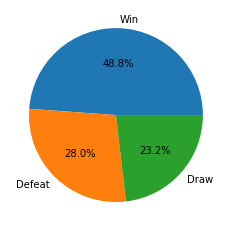

In [11]:
# Visualizing percantage of matches the home team won, lost and drew
import matplotlib.pyplot as plt

occurences = all['result'].value_counts()
plt.pie(occurences, labels = ['Win', 'Defeat', 'Draw'], autopct='%1.1f%%')

# We are aware that our dataset is not balanced y_test

In [12]:
# Assigning points to each team based on x last matches played by each team 
# (3 points for every win, 1 for every draw, 0 for every defeat)
def points_of_last_three_matches(match,matches,home_or_away_team,x = 3):

    date=match.date
    team=match[home_or_away_team]

    # Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]

    # Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    points=0

    # Calculating points based on the result
    if (home_or_away_team=='home_team_api_id'):
        for i, rows in last_matches.iterrows():
            if (last_matches['result'][i] == 'Win'):
                points += 3
            elif (last_matches['result'][i] == 'Draw'):
                points += 1
    else:
        for i, rows in last_matches.iterrows():
            if (last_matches['result'][i] == 'Defeat'):
                points += 3
            elif (last_matches['result'][i] == 'Draw'):
                points += 1

    return points

In [13]:
# Assigning points to home team and away team
all['points_home_team'] = all.apply(lambda x: points_of_last_three_matches(x, all, 'home_team_api_id'), axis = 1)
all['points_away_team'] = all.apply(lambda x: points_of_last_three_matches(x, all, 'away_team_api_id'), axis = 1)

In [14]:
# Calculating points (3 for a win, 1 for a draw and 0 for a defeat) with respect to the home team based on the results
# of the latest two matches of this particular team being a home team playing against this opponent and two as an away 
# team playing against this opponent

def last_matches_against_each_other(matches, date, home_team, away_team, x = 2):
    
    # Intializing variables for a home team and away team
    last_home_result = 0
    last_away_result = 0
    
    # Finding matches of both teams when the home team was also a home team during that match
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]
    
    # Sorting matches based on date
    last_home_matches = home_matches[home_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    # Resetting indexing
    last_home_matches.index = np.arange(1, len(last_home_matches) + 1)
    
    # Calculating points to 'last_home_result' variable
    for i, rows in last_home_matches.iterrows():
        if (last_home_matches['home_team_goal'][i] > last_home_matches['away_team_goal'][i]):
            last_home_result = last_home_result + 3
        elif (last_home_matches['home_team_goal'][i] < last_home_matches['away_team_goal'][i]):
            last_home_result = last_home_result
        else:
            last_home_result = last_home_result + 1
        
    # In case of no historical matches in dataset we assign the calculated weighted average number of points scored
    # by home team in a single match multiplied by a number of matches
    if last_home_matches.empty:
        last_home_result = (0.488*3 + 0.232*1) * x
    
    # Finding matches of both teams when the home team was an away team during that match
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    
    # Sorting matches based on date
    last_away_matches = away_matches[away_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    # Resetting indexing
    last_away_matches.index = np.arange(1, len(last_away_matches) + 1)
    
    # Calculating points to 'last_away_result' variable
    for i, rows in last_away_matches.iterrows():
        if (last_away_matches['home_team_goal'][i] > last_away_matches['away_team_goal'][i]):
            last_away_result= last_away_result
        elif (last_away_matches['home_team_goal'][i] < last_away_matches['away_team_goal'][i]):
            last_away_result = last_away_result + 3
        else:
            last_away_result = last_away_result + 1
        
    # In case of no historical matches in dataset we assign the calculated weighted average number of points scored
    # by away team in a single match multiplied by a number of matches
    if last_away_matches.empty:
        last_away_result = (0.28*3 + 0.232*1) * x
            
    return last_home_result,last_away_result

In [15]:
# Finding last matches of two teams participating within the whole dataframe and assigining the results to 'points' variable
points=all.apply(lambda x: last_matches_against_each_other(all,x.date,x.home_team_api_id,x.away_team_api_id), axis = 1)

# Adding columns 'last_home_meetings' and 'last_away_meetings' and assgining values 
all['last_home_meetings'] = list(list(zip(*points))[0])
all['last_away_meetings'] = list(list(zip(*points))[1])

In [16]:
# Sorting matches by date in order not to predict matches based on ones that did not took place yet
# Example: We don't want to predict match of 2010 based on statistics of match of 2016
all=all.sort_values('date')

In [17]:
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix

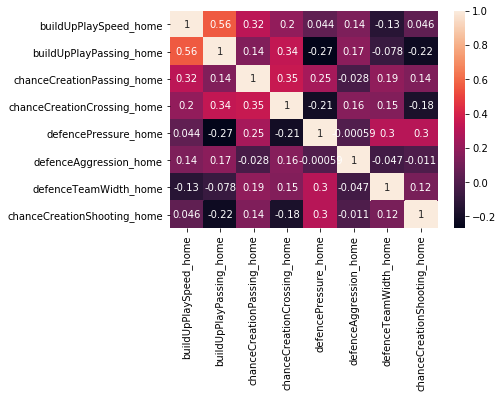

In [18]:
import seaborn as sn
import matplotlib.pyplot as plt

# Creating heatmap illustrating correlations between FIFA attributes of home team
corrMatrix = all[['buildUpPlaySpeed_home', 'buildUpPlayPassing_home', 'chanceCreationPassing_home', 
             'chanceCreationCrossing_home', 'defencePressure_home', 'defenceAggression_home',
             'defenceTeamWidth_home', 'chanceCreationShooting_home']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

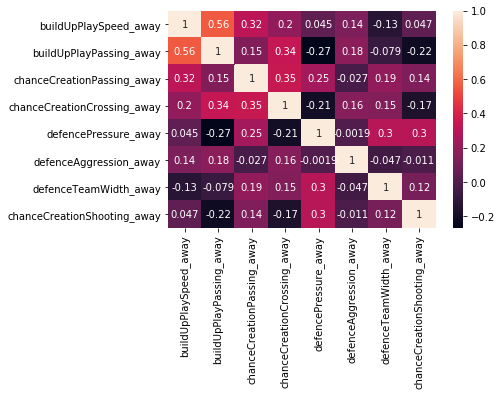

In [19]:
# Creating heatmap illustrating correlations between FIFA attributes of away team
corrMatrix = all[['buildUpPlaySpeed_away', 'buildUpPlayPassing_away', 'chanceCreationPassing_away', 
             'chanceCreationCrossing_away','defencePressure_away', 'defenceAggression_away', 
             'defenceTeamWidth_away','chanceCreationShooting_away']].corr()

sn.heatmap(corrMatrix, annot=True)
plt.show()

In [20]:
print('The shape of our features is:', all.shape)

The shape of our features is: (3040, 181)


In [21]:
# Choosing features we want to focus on while training our models and making predictions

variables = ['season','buildUpPlaySpeed_away', 'buildUpPlayPassing_away', 'chanceCreationPassing_away', 
             'chanceCreationCrossing_away','defencePressure_away', 'defenceAggression_away', 
             'defenceTeamWidth_away','chanceCreationShooting_away','buildUpPlaySpeed_home', 'buildUpPlayPassing_home',
             'chanceCreationPassing_home', 'chanceCreationCrossing_home', 'defencePressure_home',
             'defenceAggression_home','defenceTeamWidth_home', 'chanceCreationShooting_home','points_home_team',
             'points_away_team', 'last_home_meetings', 'last_away_meetings','BetsH','BetsD','BetsA']

# buildUpPlaySpeed_home - FIFA team attribute given as an integer (the bigger, the better)
# buildUpPlayPassing_home - FIFA team attribute given as an integer (the bigger, the better)
# chanceCreationPassing_home - FIFA team attribute given as an integer (the bigger, the better)
# chanceCreationCrossing_home - FIFA team attribute given as an integer (the bigger, the better)
# defencePressure_home - FIFA team attribute given as an integer (the bigger, the better)
# defenceAggression_home - FIFA team attribute given as an integer (the bigger, the better)
# defenceTeamWidth_home - FIFA team attribute given as an integer (the bigger, the better)
# chanceCreationShooting_home - FIFA team attribute given as an integer (the bigger, the better)
# all the above analogically for the away team
# season - season the match was played in, values (2008/2009 - 2015/2016)
# points_home_team - points the team participating in a match as a home team obtained in its last 3 matches within 
#the league before the date of the match (points calculated by crediting 3 points for a win, 1 for a draw and 0 for a defeat)
# last_home_meetings - points the team participating in a match as a home team obtained in its last 4 last matches 
# (2 as a home team, 2 as an away team) within the league before the date of the match with the same opponent as in 
#the considerated match (points calculated by crediting 3 points for a win, 1 for a draw and 0 for a defeat)
# BetsH - mean of the odds in decimal format for a home team win of all available data of betting sites such as Bet365, BWin, LadBrokes, William Hill and others
# BetsD - mean of the odds in decimal format for a draw of all available data of betting sites such as Bet365, BWin, LadBrokes, William Hill and others
# BetsA - mean of the odds in decimal format for an away team win of all available data of betting sites such as Bet365, BWin, LadBrokes, William Hill and others

# Dividing data into variables we will train our models on and our target data
X_all = all[variables]
y_all = all['result']

In [22]:
# Descriptive statistics for each column after concentrating on a specific number of columns
X_all.describe()

,season,buildUpPlaySpeed_away,buildUpPlayPassing_away,chanceCreationPassing_away,chanceCreationCrossing_away,defencePressure_away,defenceAggression_away,defenceTeamWidth_away,chanceCreationShooting_away,buildUpPlaySpeed_home,...,defenceAggression_home,defenceTeamWidth_home,chanceCreationShooting_home,points_home_team,points_away_team,last_home_meetings,last_away_meetings,BetsH,BetsD,BetsA
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,...,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000
mean,3.500000,47.386842,44.094737,54.026316,54.077961,49.383224,49.788816,55.742105,56.113158,47.369079,...,49.791118,55.726645,56.112171,5.047368,3.191776,3.073574,1.906653,2.737371,4.104879,5.143389
std,2.291665,12.217739,10.971091,11.203785,11.617697,10.423076,9.943381,9.346847,10.159651,12.243578,...,9.950922,9.352584,10.155986,2.240198,2.130120,1.733913,1.749607,2.405188,1.725697,5.136625
min,0.000000,20.000000,23.000000,30.000000,24.000000,30.000000,30.000000,30.000000,35.000000,20.000000,...,30.000000,30.000000,35.000000,0.000000,0.000000,0.000000,0.000000,1.041429,2.443333,1.090000
25%,1.750000,38.000000,36.000000,45.000000,45.000000,42.000000,42.000000,50.000000,50.000000,38.000000,...,42.000000,50.000000,50.000000,3.000000,1.000000,2.000000,0.000000,1.654861,3.283333,2.639722
50%,3.500000,50.000000,43.000000,55.000000,55.000000,49.000000,50.000000,56.000000,55.000000,50.000000,...,50.000000,56.000000,55.000000,5.000000,3.000000,3.392000,2.000000,2.065357,3.427778,3.566667
75%,5.250000,55.000000,53.000000,61.000000,61.000000,58.000000,56.000000,64.000000,65.000000,55.000000,...,56.000000,64.000000,65.000000,7.000000,4.000000,3.392000,3.000000,2.650278,4.059722,5.262321
max,7.000000,70.000000,73.000000,73.000000,78.000000,70.000000,70.000000,70.000000,79.000000,70.000000,...,70.000000,70.000000,79.000000,9.000000,9.000000,6.000000,6.000000,29.142857,19.214286,41.666667


In [23]:
# Standardising the data
from sklearn.preprocessing import scale

# Center to the mean and component wise scale to unit variance
# for col in [variables]:
#     X_all[col] = scale(X_all[col])

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_all = sc.fit_transform(X_all)
# X_test = sc.transform (X_test)

In [24]:
# Dividing data into training and test set taking 80% of prior data as a training set,
# so that our models are tested based on matches that took place after matches from our training set
X_train, X_test= np.split(X_all, [int(.9 *len(X_all))])
y_train, y_test= np.split(y_all, [int(.9 *len(y_all))])

# We noticed that we should predict at most one season ahead,  we splitted our data so that we predict only the outcomes
#of matches which took place in 2016 (based on matches from 2015 and earlier)

In [25]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (2736, 24)
Training Labels Shape: (2736,)
Testing Features Shape: (304, 24)
Testing Labels Shape: (304,)


In [26]:
from time import time 

# Training the classifier and measuring its time
def train_classifier(clf, X_train, y_train):
    
    # Starting the clock, training the classifier, then stoping the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Printing the results
    print ("Trained model in seconds:",end - start)

In [27]:
from sklearn.metrics import f1_score

# Making predictions 
def predict_labels(clf, features, target):
    
    # Starting the clock, making predictions, then stoping the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Printing results
    print ("Made predictions in seconds:",end - start)
    
    # Returning F1 score and accuracy
    return f1_score(target, y_pred, average=None), sum(target == y_pred) / float(len(y_pred))

In [28]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    
    # Indicating the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Training the classifier
    train_classifier(clf, X_train, y_train)
    
    # Printing the results of prediction for both training and testing set
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("===========================================")
    print ("Indexes assesing methods for training set:")
    print ("F1 score [Win  Draw  Defeat]:", f1)
    print ("Accuracy:", acc)
    
    print ("===========================================")
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("Indexes assesing methods for test set:")
    print ("F1 score [Win  Draw  Defeat]:", f1)
    print ("Accuracy:", acc)

# Training and making predictions - Linear Regression

In [29]:
clf_LR = LogisticRegression(random_state = 42)

train_predict(clf_LR, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 2736. . .
Trained model in seconds: 0.10172796249389648
Made predictions in seconds: 0.000997304916381836
Indexes assesing methods for training set:
F1 score [Win  Draw  Defeat]: [0.47175573 0.08273894 0.69633054]
Accuracy: 0.5639619883040936
Made predictions in seconds: 0.0
Indexes assesing methods for test set:
F1 score [Win  Draw  Defeat]: [0.48447205 0.16326531 0.71633238]
Accuracy: 0.5657894736842105



# Training and making predictions - XGBoost

In [30]:
import xgboost as xgb

clf_XGB = xgb.XGBClassifier(seed = 82)

train_predict(clf_XGB, X_train, y_train, X_test, y_test)
print ('')

Training a XGBClassifier using a training set size of 2736. . .
Trained model in seconds: 1.3404133319854736
Made predictions in seconds: 0.025932788848876953
Indexes assesing methods for training set:
F1 score [Win  Draw  Defeat]: [0.9987013  1.         0.99925037]
Accuracy: 0.9992690058479532
Made predictions in seconds: 0.005983829498291016
Indexes assesing methods for test set:
F1 score [Win  Draw  Defeat]: [0.46632124 0.25396825 0.60207612]
Accuracy: 0.4868421052631579



# Tunning - XGBoost

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Defining parameters we want to tune
parameters = { 'learning_rate' : [0.5,0.8,0.1,0.15],
               'n_estimators' : [80,100,120],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.7] }

# Initializing the classifier
clf_XGB = xgb.XGBClassifier(seed=2)

# Performing grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf_XGB,
                        scoring='f1_macro',
                        param_grid=parameters,
                        cv=5,
                        verbose=1)

grid_obj = grid_obj.fit(X_train,y_train)

clf_XGB = grid_obj.best_estimator_

# Printing out best found parameters
grid_obj.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   40.5s finished


{'colsample_bytree': 0.7,
 'gamma': 0.4,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 100,
 'subsample': 0.8}

# Making predictions after tunning - XGBoost

In [32]:
#Print the results of prediction for training set after parameter tuning
f1, acc = predict_labels(clf_XGB, X_train, y_train)
print ("Indexes assesing methods for training set:")
print ("F1 score [Win  Draw  Defeat]:", f1)
print ("Accuracy:", acc)

Made predictions in seconds: 0.0229647159576416
Indexes assesing methods for training set:
F1 score [Win  Draw  Defeat]: [0.55841293 0.27075351 0.734375  ]
Accuracy: 0.6242690058479532


In [33]:
#Print the results of prediction for testing set after parameter tuning
f1, acc = predict_labels(clf_XGB, X_test, y_test)
print ("Indexes assesing methods for test set:")
print ("F1 score [Win  Draw  Defeat]:", f1)
print ("Accuracy:", acc)

Made predictions in seconds: 0.03503227233886719
Indexes assesing methods for test set:
F1 score [Win  Draw  Defeat]: [0.51428571 0.24742268 0.7202381 ]
Accuracy: 0.5855263157894737


In [34]:
# Printing features importance in decreasing order
feature_imp_xg = pd.Series(clf_XGB.feature_importances_,index=variables).sort_values(ascending=False)
feature_imp_xg

BetsH                          0.115913
BetsA                          0.103876
BetsD                          0.048266
season                         0.039114
defencePressure_home           0.038247
chanceCreationPassing_away     0.037628
buildUpPlayPassing_home        0.037466
defenceTeamWidth_home          0.037082
chanceCreationShooting_home    0.036664
defenceAggression_home         0.036637
defencePressure_away           0.036549
buildUpPlaySpeed_home          0.035887
chanceCreationShooting_away    0.035689
points_away_team               0.034606
chanceCreationCrossing_home    0.034311
points_home_team               0.033969
last_away_meetings             0.033492
defenceAggression_away         0.032726
buildUpPlayPassing_away        0.032689
chanceCreationPassing_home     0.032574
last_home_meetings             0.032516
defenceTeamWidth_away          0.032023
buildUpPlaySpeed_away          0.031584
chanceCreationCrossing_away    0.030492
dtype: float32

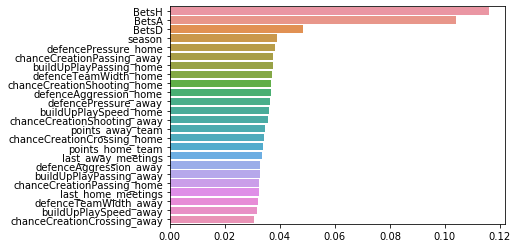

In [35]:
import seaborn as sns
%matplotlib inline

# Plotting features importance
sns.barplot(x=feature_imp_xg, y=feature_imp_xg.index)

# Training and making predictions - Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Creating a Gaussian Classifier
clf_RF=RandomForestClassifier(n_estimators=100)

# Making predicitons
train_predict(clf_RF, X_train, y_train, X_test, y_test)
print ('')

Training a RandomForestClassifier using a training set size of 2736. . .
Trained model in seconds: 0.7934269905090332
Made predictions in seconds: 0.07775449752807617
Indexes assesing methods for training set:
F1 score [Win  Draw  Defeat]: [1. 1. 1.]
Accuracy: 1.0
Made predictions in seconds: 0.0329132080078125
Indexes assesing methods for test set:
F1 score [Win  Draw  Defeat]: [0.48275862 0.25862069 0.68553459]
Accuracy: 0.5460526315789473



# Tunning - Random Forest

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Defining parameters we want to tune
parameters = { 
    'n_estimators': [250,300,350],
    'max_features': ['auto','log2'],
    'min_samples_leaf': [40,45,50],
    'max_depth': [10,15,20],
    'random_state': [42]
}

random_grid = GridSearchCV(clf_RF, parameters, cv = 5, verbose = 1)
random_grid = random_grid.fit(X_train,y_train)

clf_RF = random_grid.best_estimator_

# Printing out best found parameters
random_grid.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  4.6min finished


{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 45,
 'n_estimators': 250,
 'random_state': 42}

# Making predictions after tunning - Random Forest

In [38]:
# Printing the results of prediction for training set after parameter tuning
f1, acc = predict_labels(clf_RF, X_train, y_train)
print ("Indexes assesing methods for training set:")
print ("F1 score [Win  Draw  Defeat]:", f1)
print ("Accuracy:", acc)

Made predictions in seconds: 0.09477949142456055
Indexes assesing methods for training set:
F1 score [Win  Draw  Defeat]: [0.50672646 0.03697997 0.70588235]
Accuracy: 0.5778508771929824


In [39]:
# Printing the results of prediction for testing set after parameter tuning
f1, acc = predict_labels(clf_RF, X_test, y_test)
print ("Indexes assesing methods for test set:")
print ("F1 score [Win  Draw  Defeat]:", f1)
print ("Accuracy:", acc)

Made predictions in seconds: 0.037866830825805664
Indexes assesing methods for test set:
F1 score [Win  Draw  Defeat]: [0.5        0.02702703 0.70984456]
Accuracy: 0.5756578947368421


In [40]:
# Printing features importance in decreasing order
feature_imp = pd.Series(clf_RF.feature_importances_,index=variables).sort_values(ascending=False)
feature_imp

BetsH                          0.285631
BetsA                          0.221309
BetsD                          0.096003
defencePressure_home           0.033120
buildUpPlayPassing_home        0.032942
last_home_meetings             0.027949
buildUpPlayPassing_away        0.026575
chanceCreationPassing_away     0.025036
defencePressure_away           0.023710
defenceTeamWidth_away          0.022313
last_away_meetings             0.020762
defenceTeamWidth_home          0.020419
chanceCreationShooting_home    0.019732
buildUpPlaySpeed_away          0.018641
buildUpPlaySpeed_home          0.016906
chanceCreationShooting_away    0.016394
chanceCreationCrossing_home    0.014665
chanceCreationPassing_home     0.014393
defenceAggression_home         0.013763
chanceCreationCrossing_away    0.013368
season                         0.012457
defenceAggression_away         0.009173
points_home_team               0.008657
points_away_team               0.006081
dtype: float64

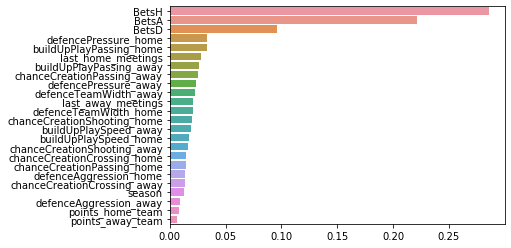

In [41]:
import seaborn as sns
%matplotlib inline
# Plotting features importance
sns.barplot(x=feature_imp, y=feature_imp.index)

# Time for some testing and your activity :)

In [42]:
from tabulate import tabulate

def individual_examples_testing(first_team, second_team):
    test_example = all.loc[all['season'].isin([7]) & all['team_long_name_home'].isin([first_team, second_team]) & all['team_long_name_away'].isin([first_team, second_team])]
    X_test_example = test_example[variables]
    y_test_example = test_example['result']
    
    X_test_example = sc.transform(X_test_example)
    
    y_pred_LR = clf_LR.predict(X_test_example)
    y_pred_XGB = clf_XGB.predict(X_test_example)
    y_pred_RF = clf_RF.predict(X_test_example)
    
    display(test_example[['team_long_name_home', 'home_team_goal', 'away_team_goal', 'team_long_name_away']])
    
    print(tabulate([['Actual result',list(y_test_example)], ['LR', y_pred_LR], ['XGB', y_pred_XGB], ['RF', y_pred_RF]], headers=['','Predictions'], tablefmt='orgtbl'))
    
#     return test_example['result'], y_pred_LR, y_pred_XGB, y_pred_RF

# Possible teams:
### - FC Barcelona
### - Real Madrid CF
### - Granada CF
### - Real Betis Balompié
### - Levante UD

In [43]:
first_team = 'Real Madrid CF'
second_team = 'Granada CF'

individual_examples_testing(first_team, second_team)

,team_long_name_home,home_team_goal,away_team_goal,team_long_name_away
2987,Real Madrid CF,1,0,Granada CF
2817,Granada CF,1,2,Real Madrid CF


|               | Predictions       |
|---------------+-------------------|
| Actual result | ['Win', 'Defeat'] |
| LR            | ['Win' 'Defeat']  |
| XGB           | ['Win' 'Defeat']  |
| RF            | ['Win' 'Defeat']  |
